# GraphSAGE Implementation
> Link Stealing Attack

#### Imports

In [1]:
import argparse
import time
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl import DGLGraph
from dgl.data import register_data_args, load_data
from dgl.nn.pytorch.conv import SAGEConv
import matplotlib.pyplot as plt

Using backend: pytorch


#### Random

In [2]:
import random
random.seed(1)

#### Dataset

- social network
- nodes being people
- connected if they know each other
- features contain
    - `City` they live in
    - `Street` they live in
    - `Age`
- `School` being the label which the GNN aims to predict

In [3]:
def generate_DGLGraph(node_amount):
    # initialize Graph
    G = dgl.DGLGraph()
    
    # Add node_amount nodes
    G.add_nodes(node_amount)
    G.ndata['x'] = torch.zeros((node_amount, 3), dtype=torch.int64)
    G.ndata['label'] = torch.zeros((node_amount, 1), dtype=torch.int64)
    
    # generate ...
    for i in range(node_amount):
        # features
        street = random.randint(0, 49)
        city   = 0 if street < 10 else int(street / 10)
        age    = random.randint(5, 20)
        G.nodes[i].data['x'] = torch.tensor([[city, street, age]], dtype=torch.int64)
        
        # labels
        school = random.randint(0, 10)
        G.nodes[i].data['label'] = torch.tensor([[school]], dtype=torch.int64)
        
    # generate edges
    pairs = []
    src_list, dst_list = [], []
    for i in range(node_amount):
        for j in range(node_amount):
            # no self loops
            if i == j:
                continue
            
            if know_each_other(G.ndata, i, j) and (i, j) not in pairs:
                src_list.append(i)
                src_list.append(j)
                dst_list.append(j)
                dst_list.append(i)
                pairs.append((i, j))
                pairs.append((j, i))
                
    G.add_edges(src_list, dst_list)
    
    return G

The label `School` is also used for deciding whether they know each other or not

In [4]:
def know_each_other(data, i, j, threshold=0.4):
    score = 0.0
    
    x, x_school = data['x'][i], data['label'][i].item()
    y, y_school = data['x'][j], data['label'][j].item()
    
    # City : Street : School & Age
    score += 0.25 if x[0].item() == y[0].item() else 0.1
    score += 0.25 if abs(x[1].item() - y[1].item()) < 4 else 0.1
    score += 0.5 if x_school == y_school and abs(x[2].item() - y[2]) < 2 else 0.2 if x_school == y_school else 0.0 
    
    return True if score >= threshold else False

#### Generate new Social Network

In [5]:
AMOUNT_OF_MEMBERS = 30
social_network_graph = generate_DGLGraph(AMOUNT_OF_MEMBERS)

/home/us3r/Documents/Projekte/Bachelor-Thesis/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


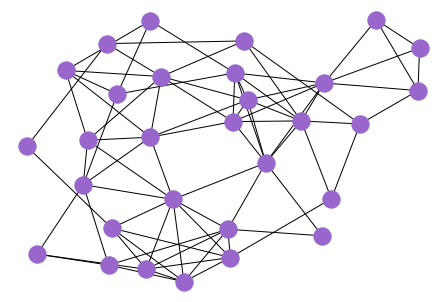

In [7]:
nx_graph = social_network_graph.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, node_color=[[.6, .4, .8]])